In [1]:
#################################################################################
#####   INF889E - Méthodes d'intelligence artificielle en bioinformatique   #####
#####             Classification de VIH par zones géographiques             #####
#################################################################################
#####   Author: Riccardo Z******                                            #####
#####   This program is partly inspired by the work presented in a class    #####
#####   workshop by Dylan Lebatteux.                                        #####
#################################################################################

In [2]:
# Import functions
import re
import joblib
import numpy as np
import pandas as pd
from os import listdir
from random import shuffle
from progressbar import ProgressBar
from Bio import SeqIO, pairwise2
from Bio.motifs import create
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from dna_features_viewer import GraphicFeature, GraphicRecord
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
##############################################
#####        IMPORTANT VARIABLES         #####
##############################################

In [4]:
# Scope of classification: if "ALL", classify by region globaly
# If AFR, ASI, CAM, CRB, EUR, FSU, MEA, NAM, OCE or SAM, classify by country within this chosen region 
scope = "NAM"
# Access path for the FASTA files (one file for each region)
path = "../../../../data/" + "mixed"
# Name of trained model when saving
model_name = "nam.pkl"
# For sampling purposes: will process max n sequences for each target class
n_samples = 250000
# Classification features as sum (false) of motifs or as frequency (true) of motifs
freq = False
# Elimination step for features selection
step = 5
# Number of features to select
n_features = 100
# Train / Test split ratio
split_raito = 0.8
# Dimensions for graphs (2D or 3D)
n_components = 2
# Set maximum number of incorrect records to analyse at the end
max_incorrect = 10
# Set maximum number of correct records to compute alignment with at the end
max_correct = 1000
# Set the length k of the features based on k-mers
k = 5

In [5]:
##############################################
#####        DATA INITIALISATION         #####
##############################################
print("\n         DATA INITIALISATION         ")
print("=====================================")


         DATA INITIALISATION         


In [6]:
# Will contain all the data rows, in the form of biopython seq_records objects
data = []
# Will contain a pair of target class -> number of data rows with this target class
targets = {}
# Process raw record label information into its annotations, then insert it into data
# To update if the label of sequences in the FASTA files changes
def add_record(record, target):
    # Initialiation of the seq_record
    header = record.id.split(".")
    record.id = header[4]
    record.name = header[3]
    record.seq = record.seq.upper()
    record.annotations = {"target": target, "subtype": header[0], "country": header[1]}
    # Add it to the data table and update the target classes dictionary
    targets[target] = targets.get(target, 0) + 1
    data.append(record)


In [7]:
# Properly fills the data table using the above function
if scope == "ALL":
    # Used to show progress
    progress = ProgressBar()
    # If scope is ALL, each filename is the name of each region used as a target class
    for filename in progress(listdir(path)):
        target = filename.split('.')[0]
        for record in SeqIO.parse(path + "/" + filename, "fasta"):
            add_record(record, target)
    print("")
else:
    # Else, countries are target classes, and the scope region is the filename
    for record in SeqIO.parse(path + "/" + scope + ".fasta", "fasta"):
        target = record.id.split(".")[1]
        add_record(record, target)


In [8]:
# Dipslay data information
print("Data information:")
print("Number of sequences:", sum(targets.values()))
print("Number of targets:", len(targets))
print("Minimum number of instances:", min(targets.values()))
print("Maximum number of instances:", max(targets.values()))

# Dipslay data summary
print("\nData summary:")
for key, value in targets.items(): 
    print("Target:", key, "| Number of sequences:", value)

# Display the first 5 samples
print("\nInformation of the first 5 samples:")
for i in range(5):
    print("ID:", data[i].id, "| Sequence:", data[i].seq[0:50], "| Annotations:", data[i].annotations)


Data information:
Number of sequences: 5223
Number of targets: 2
Minimum number of instances: 66
Maximum number of instances: 5157

Data summary:
Target: US | Number of sequences: 5157
Target: CA | Number of sequences: 66

Information of the first 5 samples:
ID: AB078005 | Sequence: CAAGGATCCTTCCCTGATTGGCAGAACTACACACCAGGGCCAGGGGTCAG | Annotations: {'target': 'US', 'subtype': 'B', 'country': 'US'}
ID: AB221005 | Sequence: TGGATGGGCTAATTTACTCCCAAAAAAGACAAGATATCCTTGATTTGTGG | Annotations: {'target': 'US', 'subtype': 'B', 'country': 'US'}
ID: AB253432 | Sequence: TGGATGGGCTAATTTACTCCCAAAAAAGACAAGATATCCTTGATTTGTGG | Annotations: {'target': 'US', 'subtype': 'B', 'country': 'US'}
ID: AB485638 | Sequence: GGAAGGGCTAATTCACTCCCAAAGAAGGCAAGATATCCTTGATCTGTGGG | Annotations: {'target': 'US', 'subtype': 'B', 'country': 'US'}
ID: AB485639 | Sequence: GGATGGGCTAATTTACTCCCAAAAAAGAAAAGATATCCTTGATCTGTGGG | Annotations: {'target': 'US', 'subtype': 'B', 'country': 'US'}


In [9]:
##############################################
#####      TRAIN / TEST DATA SPLIT       #####
##############################################
# Initialise train/test tables that will contain the data
train_data = []
test_data = []
# Initialise train/test dictionaries that will contain the number of instances for each target
test_split = {}
train_split = {}
# Initialise the dictionary with the targets keys and the value 0
test_split = test_split.fromkeys(targets.keys(), 0)
train_split = train_split.fromkeys(targets.keys(), 0)
# Shuffle the data
shuffle(data)

In [10]:
# Iterate through the data
for d in data:
    # Get this records's target class
    target = d.annotations["target"]
    # For sampling purposes: train/test threshold is based on n_samples if there is too much records for this target
    threshold = min(targets[target], n_samples) * split_raito
    # Until threshold for this target is reached, fills train data
    if train_split[target] < threshold: 
        train_data.append(d)
        train_split[target] += 1
    # Then, fills test data (until eventually n_samples are collected)
    elif test_split[target] < n_samples * (1-split_raito): 
        test_data.append(d)
        test_split[target] += 1
# Shuffle the data
shuffle(train_data)
shuffle(test_data)

In [11]:
# Data summary of the train/test split
print("\nTrain/Test split summary:")
for train_key, test_key in zip(train_split.keys(), test_split.keys()):
    print("Target:", train_key, "| Train instances:", train_split[train_key], "| Test instances:", test_split[test_key])
print("\nTotal number of training instances:", len(train_data))
print("Total number of testing instances:", len(test_data))


Train/Test split summary:
Target: US | Train instances: 4126 | Test instances: 1031
Target: CA | Train instances: 53 | Test instances: 13

Total number of training instances: 4179
Total number of testing instances: 1044


In [12]:
##################################################
#####  FEATURES GENERATION BASED ON K-MERS   #####
##################################################
print("\n         FEATURES GENERATION         ")
print("=====================================")


         FEATURES GENERATION         


In [13]:
# Initialize an empty dictionary for the k-mers motifs features
instances = {}
# Used to show progress
progress = ProgressBar()
# Iterate through the training data
for d in train_data:
    # Go through the sequence 
    for i in range(0, len(d.seq) - k + 1, 1):
        # Get the current k-mer motif feature
        feature = str(d.seq[i:i + k])
        # If it contains only the characters "A", "C", "G" or "T", it will be saved
        if re.match('^[ACGT]+$', feature): 
            instances[feature] = 0
    progress.update(len(instances))
    # No need to keep going if motifs dictonary reaches max size
    if len(instances) == 4 ** k:
        break
# Used to show progress
progress.finish()
# Save dictonary keys as biopython motifs object
motifs = create(instances.keys())
# Display the number of features
print("\nNumber of features:", len(motifs.instances), "\n")

| |                       #                        | 1024 Elapsed Time: 0:00:02

Number of features: 1024 



In [14]:
######################################################################
##### GENERATION OF THE FEATURE MATRIX (x) AND TARGET VECTOR (y) #####
######################################################################

In [15]:
# Function to generate feature matrix and target vector
def generateFeatures(data):
    # Initialize the feature matrix
    X = []
    # Initialize the target vector
    y = []
    # Used to show progress
    progress = ProgressBar()
    # Iterate through the data
    for d in progress(data):
        # Generate an empty dictionary
        x = {}
        # Initialize the dictionary with targets as keys and 0 as value
        x = x.fromkeys(motifs.instances, 0)
        # Compute X (features matrix): the number of occurrence of k-mers (with overlaping)
        for i in range(0, len(d.seq) - k + 1, 1):
            feature = d.seq[i:i + k]
            # Attempt to increment the number of occurrences of the current k-mer feature
            try: x[feature] += 1
            # It could fail because the current k-mer is not full ACGT
            except: pass
        # Save the features vector in the features matrix
        X.append(list(x.values()))
        # Save the target class in the target vector
        y.append(d.annotations["target"])
    # Return matrices X and y (feature matrix and target vector)
    return X, y

In [16]:
# Generate train/test feature matrices and target vectors
x_train, y_train = generateFeatures(train_data)
x_test, y_test = generateFeatures(test_data)

100% (4179 of 4179) |####################| Elapsed Time: 0:03:35 Time:  0:03:35
100% (1044 of 1044) |####################| Elapsed Time: 0:00:46 Time:  0:00:46


In [17]:
# Function to generate feature matrix and target vector based on k-mer frequency, not the sum
def generateFreqFeatures(x_sum):
    X = []
    for x in x_sum:
        total = sum(x)
        X.append(list(map((lambda i: i / total), x)))
    return X

In [18]:
# If Freq is ture, then the features matrix are frequency of k-mers, not their sum
if freq:
    x_train = generateFreqFeatures(x_train)
    x_test = generateFreqFeatures(x_test)

In [19]:
##############################################
#####       FEATURES NORMALISATION       #####
##############################################

In [20]:
# Instantiate a MinMaxScaler between 0 and 1
minMaxScaler = MinMaxScaler(feature_range = (0,1))
# Apply a scaling to the train and test set
x_train = minMaxScaler.fit_transform(x_train)
x_test = minMaxScaler.fit_transform(x_test)

In [21]:
##############################################
#####         FEATURES SELECTION         #####
##############################################
print("\n         FEATURES SELECTION          ")
print("=====================================")


         FEATURES SELECTION          


In [22]:
# Instantiate a linear model based on svm
model = svm.SVC(C = 1.0, kernel='linear', class_weight = None)
# Instantiate the RFE
rfe = RFE(model, n_features_to_select = n_features, step = step, verbose=True)
# Apply RFE and transform the training matrix
x_train = rfe.fit_transform(x_train, y_train)
# Tranform the test matrix (will be useed later for evaluation purposes)
x_test = rfe.transform(x_test)

Fitting estimator with 1024 features.
Fitting estimator with 1019 features.
Fitting estimator with 1014 features.
Fitting estimator with 1009 features.
Fitting estimator with 1004 features.
Fitting estimator with 999 features.
Fitting estimator with 994 features.
Fitting estimator with 989 features.
Fitting estimator with 984 features.
Fitting estimator with 979 features.
Fitting estimator with 974 features.
Fitting estimator with 969 features.
Fitting estimator with 964 features.
Fitting estimator with 959 features.
Fitting estimator with 954 features.
Fitting estimator with 949 features.
Fitting estimator with 944 features.
Fitting estimator with 939 features.
Fitting estimator with 934 features.
Fitting estimator with 929 features.
Fitting estimator with 924 features.
Fitting estimator with 919 features.
Fitting estimator with 914 features.
Fitting estimator with 909 features.
Fitting estimator with 904 features.
Fitting estimator with 899 features.
Fitting estimator with 894 featur

In [23]:
# Compute the reduction percentage of the feature matrix
reduction_percentage = ((len(motifs.instances) - n_features) / len(motifs.instances) * 100)
# Print the reduction percentage
print("\nReduction percentage:", round(reduction_percentage, 2), "%")


Reduction percentage: 90.23 %


In [24]:
# Initialize the table that will contain the selected features
instances = []
# Save selected k-mers features
for i, mask in enumerate(rfe.support_): 
    if mask == True: instances.append(motifs.instances[i])
# Save table as biopython motifs object
features = create(instances)


In [25]:
##############################################
#####    TRAINING DATA VISUALISATION     #####
##############################################
print("\n     TRAINING DATA VISUALISATION     ")
print("=====================================")


     TRAINING DATA VISUALISATION     


In [26]:
# Define the function to draw Scatter Plot
def generateScatterPlot(title, figure_width, figure_height, data, X, y):
    # If 2d dimensions
    if n_components == 2:
        # Initialize a 2-dimensional figure
        fig, ax = plt.subplots(figsize=(figure_width, figure_height))
    # If 3d dimensions
    else:
        # Initialize a 3-dimensional figure
        fig = plt.figure(figsize=(15, 10))
        ax = Axes3D(fig)
    # List of markers
    markers = ["o","+", "^", "x"]
    # List of colors
    colors = ["tab:blue", "tab:orange", 
              "tab:green", "tab:red", 
              "tab:purple", "tab:brown", 
              "tab:pink", "tab:grey", 
              "tab:olive", "tab:cyan",]
    
    # Iterate through the targets
    for i, target in enumerate(y):
        # Set the list of axis positions
        x = []
        y = []
        z = []
        # If the number of targets is less than 10
        if i < 10:
            color = colors[i]
            marker = markers[0]
        # If the number of targets is less than 20
        elif i < 20:
            color = colors[i-10]
            marker = markers[1]
        # If the number of targets is less than 30
        elif i < 30:
            color = colors[i-20]
            marker = markers[2]
        # If the number of targets is less than 40
        else:
            color = colors[i-30]
            marker = markers[3]
            
        # Iterate through the data
        for i, d in enumerate(data):
            # If the sequence belongs to the target of interest
            if d.annotations["target"] == target:
                # Save the value of the positions
                x.append(X[i][0])
                y.append(X[i][1])
                if n_components == 3: z.append(X[i][2])
              
        # Add the current scatter plot to the figure
        if n_components == 2:
            ax.scatter(x, y, c = color, label = target, alpha = 0.75, edgecolors = 'none', marker=marker)
        else:
            ax.scatter(x, y, z, c = color, label=target,alpha=0.75, edgecolors='none', marker=marker)

    # Display the grid
    ax.grid(True)
    # Set the legend parameters
    ax.legend(loc = 2, prop = {'size': 10})
    # Set the tite
    plt.title(title)
    # Set axes labels
    if n_components == 2:
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    else: 
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
    # Displqy the figure
    plt.show()

In [27]:
# Instantiate a TSNE with 3 principal components
tsne = TSNE(n_components = 3, perplexity = 50, verbose=True)
# Apply TSNE to X_train
x_tsne = tsne.fit_transform(x_train)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4179 samples in 0.002s...
[t-SNE] Computed neighbors for 4179 samples in 1.817s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4179
[t-SNE] Computed conditional probabilities for sample 2000 / 4179
[t-SNE] Computed conditional probabilities for sample 3000 / 4179
[t-SNE] Computed conditional probabilities for sample 4000 / 4179
[t-SNE] Computed conditional probabilities for sample 4179 / 4179
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.055809
[t-SNE] KL divergence after 1000 iterations: 0.571341


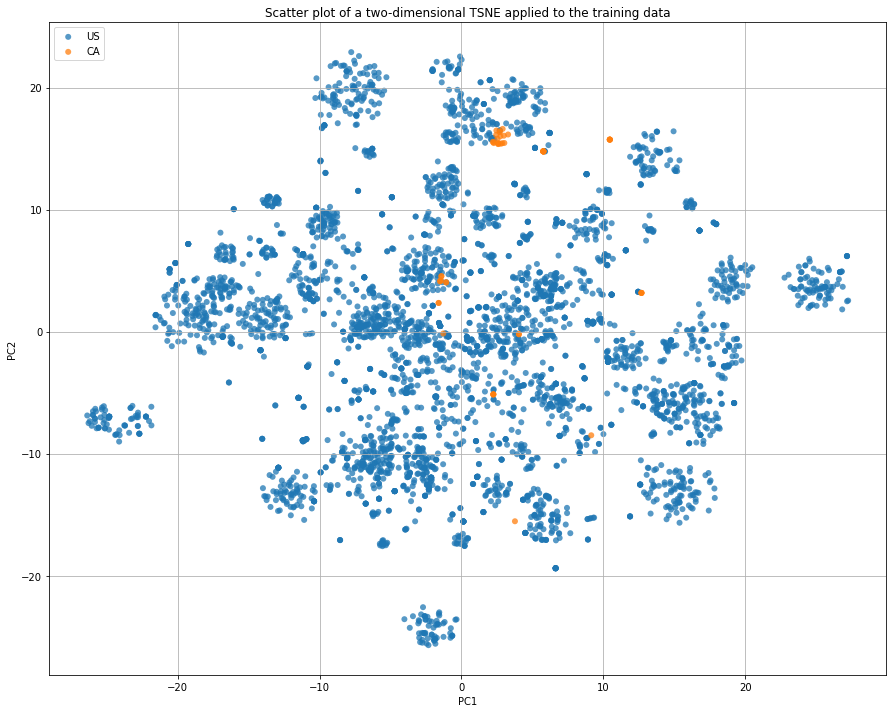

In [28]:
# Generate scatter plot of a TSNE
generateScatterPlot(title= "Scatter plot of a two-dimensional TSNE applied to the training data", 
                    figure_width = 15, 
                    figure_height = 12, 
                    data = train_data, 
                    X = x_tsne, 
                    y = set(y_train))

In [29]:
# Instantiate PCA with 3 principal components
pca = PCA(n_components = 3)
x_pca =  pca.fit_transform(x_train)

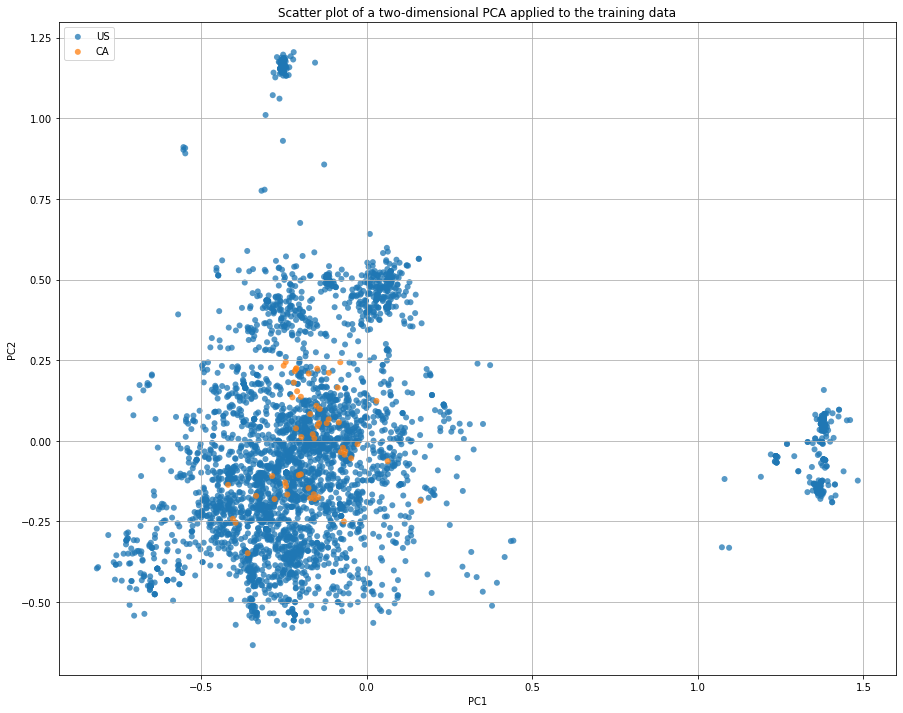

In [30]:
# Generate scatter plot of a PCA
generateScatterPlot(title= "Scatter plot of a two-dimensional PCA applied to the training data", 
                    figure_width = 15, 
                    figure_height = 12, 
                    data = train_data, 
                    X = x_pca, 
                    y = set(y_train))

In [31]:
##############################################
#####   MODEL TRAINING AND PREDICTION    #####
##############################################
print("\n    MODEL TRAINING AND PREDICTION    ")
print("=====================================")


    MODEL TRAINING AND PREDICTION    


In [32]:
# Fit the model on the train set
model.fit(x_train, y_train)
# Save the model to filename model_name
joblib.dump(model, model_name)

['nam.pkl']

In [33]:
# Predict with model on the test set
y_pred = model.predict(x_test)
# Display prediction
print("Predictions (" + str(len(y_pred)) + "):", y_pred)

Predictions (1044): ['US' 'US' 'US' ... 'US' 'US' 'US']


In [34]:
##############################################
#####  MODEL PREDICTIONS VISUALISATION   #####
##############################################
print("\n   MODEL PREDICTIONS VISUALISATION   ")
print("=====================================")


   MODEL PREDICTIONS VISUALISATION   


In [35]:
# Will contain correct and incorrect data seq_records objects
correct_data = []
incorrect_data = []
# Will contain correct and incorrect features vectors (just like x_test)
correct_features = []
incorrect_features = []
# Iterate through test data
for i, d in enumerate(test_data):
    # Add an annotation to all test data stating its percentage range of ACGT characters
    total_char = len(d.seq)
    total_acgt = 0
    for char in d.seq:
        if re.match('^[ACGT]+$', char):
            total_acgt += 1
    acgt_percent = total_acgt / total_char
    if acgt_percent >= 0.75: d.annotations["acgt-percent"] = "75-100"
    elif acgt_percent >= 0.50: d.annotations["acgt-percent"] = "50-75"
    elif acgt_percent >= 0.25: d.annotations["acgt-percent"] = "25-50"
    else: d.annotations["acgt-percent"] = "0-25"
    # Split test data into correct and incorrect sets depending on prediction results
    if y_pred[i] == d.annotations["target"]:
        correct_data.append(d)
        correct_features.append(x_test[i])
    else:
        # If it's incorrect, add the prediction class as an annotation
        d.annotations["prediction"] = y_pred[i]
        incorrect_data.append(d)
        incorrect_features.append(x_test[i])

In [36]:
# Print the classification_report
print(classification_report(y_test, y_pred, digits = 3))

              precision    recall  f1-score   support

          CA      1.000     0.769     0.870        13
          US      0.997     1.000     0.999      1031

    accuracy                          0.997      1044
   macro avg      0.999     0.885     0.934      1044
weighted avg      0.997     0.997     0.997      1044



In [37]:
# Dictonaries with pair of annotation -> number of incorrect records with this annotation
subtypes = {}
countries = {}
predictions = {}
acgt_percents = {}
# Iterate through incorrect data
for i in incorrect_data:
    # Increment each kind of annotation with current record values as keys
    subtypes[i.annotations["subtype"]] = subtypes.get(i.annotations["subtype"], 0) + 1
    countries[i.annotations["country"]] = countries.get(i.annotations["country"], 0) + 1
    predictions[i.annotations["prediction"]] = predictions.get(i.annotations["prediction"], 0) + 1
    acgt_percents[i.annotations["acgt-percent"]] = acgt_percents.get(i.annotations["acgt-percent"], 0) + 1
# Display number of incorrect records for each annotation, useful to spot any pattern here
print("Incorrect predictions annotations:")
print("Subtype:", subtypes)
print("Country:", countries)
print("Prediction:", predictions)
print("ACGT percent:", acgt_percents)

Incorrect predictions annotations:
Subtype: {'B': 2, 'U': 1}
Country: {'CA': 3}
Prediction: {'US': 3}
ACGT percent: {'75-100': 3}


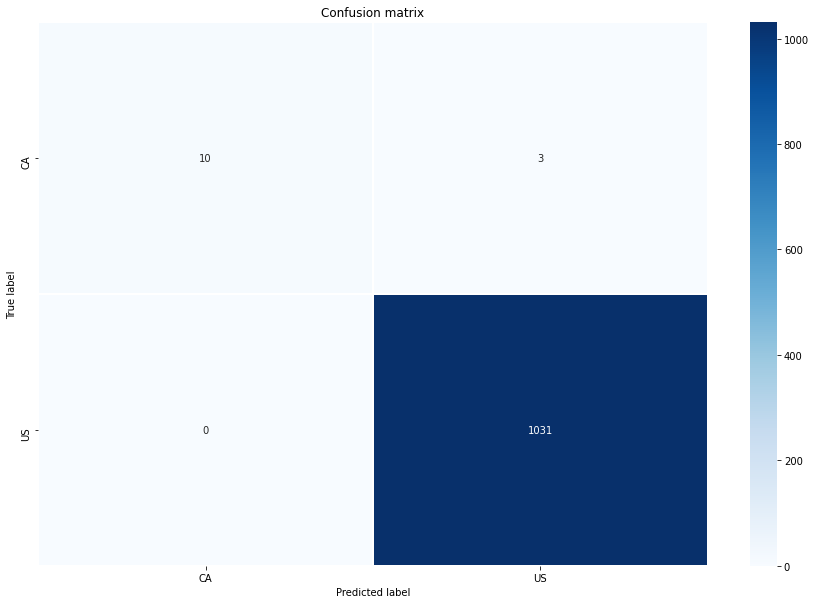

In [38]:
# Compute the confusion matrix
matrix = confusion_matrix(y_true = y_test, y_pred = y_pred, labels=sorted(targets.keys()))
# Build the heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(matrix, 
            cmap = 'Blues', 
            annot = True, 
            fmt = ".0f", 
            linewidth = 0.1, 
            xticklabels = sorted(targets.keys()), 
            yticklabels = sorted(targets.keys()))
plt.title("Confusion matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

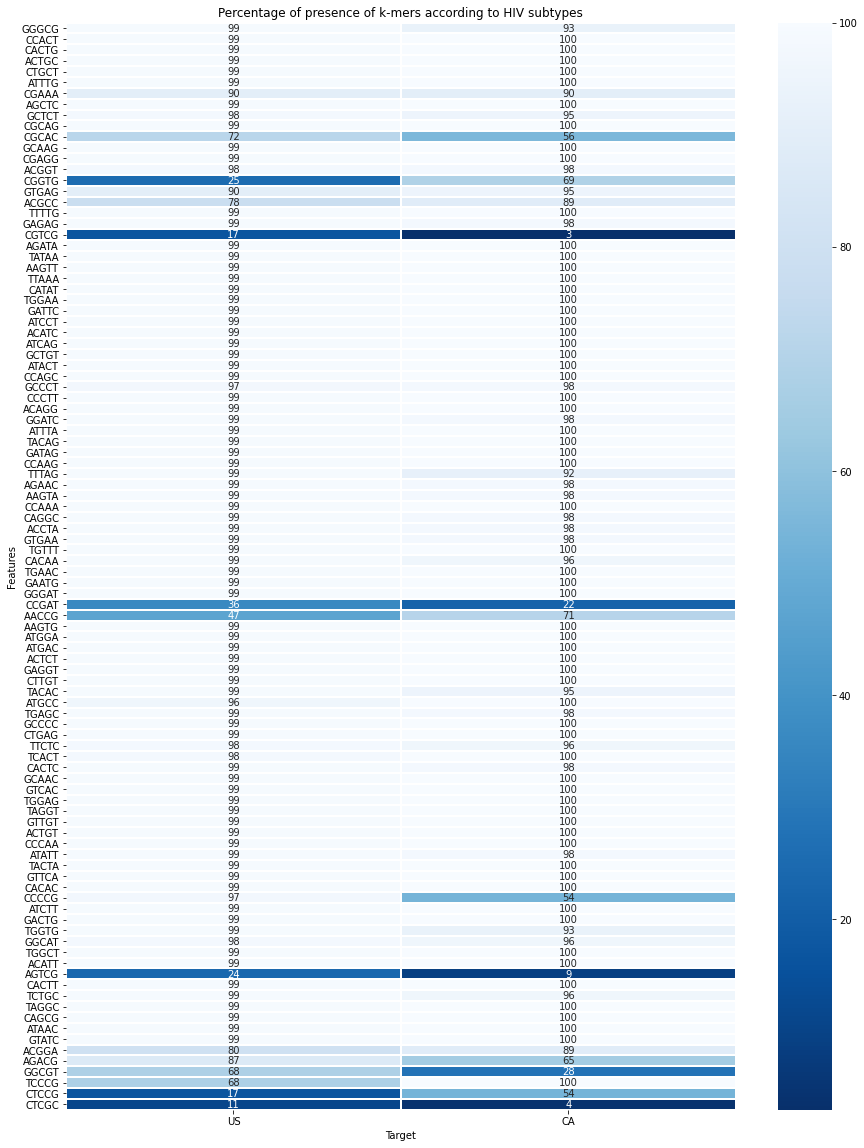

In [39]:
# Show percentage of occurence of all features for all target classes in both train and test data
matrix = []
# Iterate through features
for i, feature in enumerate(features.instances):
    # Generate an empty dictionary
    x = {}
    # Initialize the dictionary with targets as keys and 0 as value
    x = x.fromkeys(targets.keys(), 0)
    # Count in all train data
    for f, d in zip(x_train, train_data):
        if f[i] > 0: x[d.annotations["target"]] += 1
    # Count in all test data
    for f, d in zip(x_test, test_data):
        if f[i] > 0: x[d.annotations["target"]] += 1
    # Vector of attendance percentage
    vector = []
    # Iterate through the number of instances and the number of occurrences
    for n_instances, n_occurrences in zip(targets.values(), x.values()):
        n_instances = min(n_instances, n_samples)
        # Compute the percentage of k-mers attendance by target
        attendance_percentage = 100 - ((n_instances - n_occurrences) / n_instances * 100)
        # Save the attendance percentage in the specitic vector
        vector.append(int(attendance_percentage))
    # Save the vector of attendance percentage in the heatmap matrix
    matrix.append(vector)
# Build the heatmap
fig, ax = plt.subplots(figsize=(15, 20))
sns.heatmap(matrix, 
            annot = True, 
            fmt = ".0f", 
            cmap = 'Blues_r',
            linewidth = 0.1, 
            xticklabels = targets.keys(), 
            yticklabels = features.instances)
plt.title("Percentage of presence of k-mers according to HIV subtypes")
plt.xlabel("Target")
plt.ylabel("Features")
plt.show()

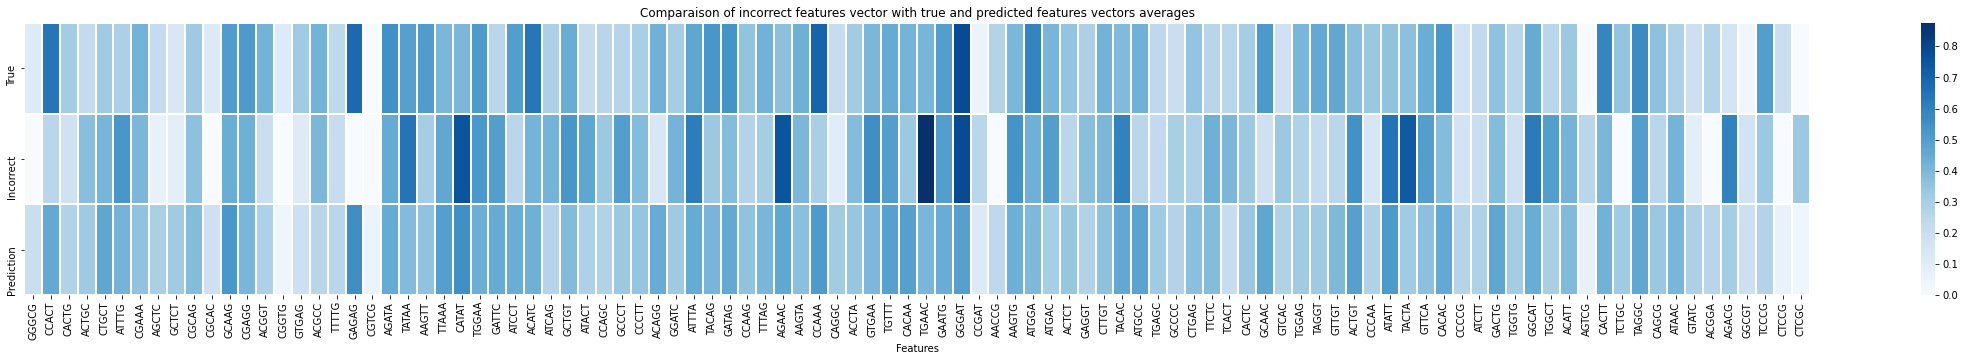

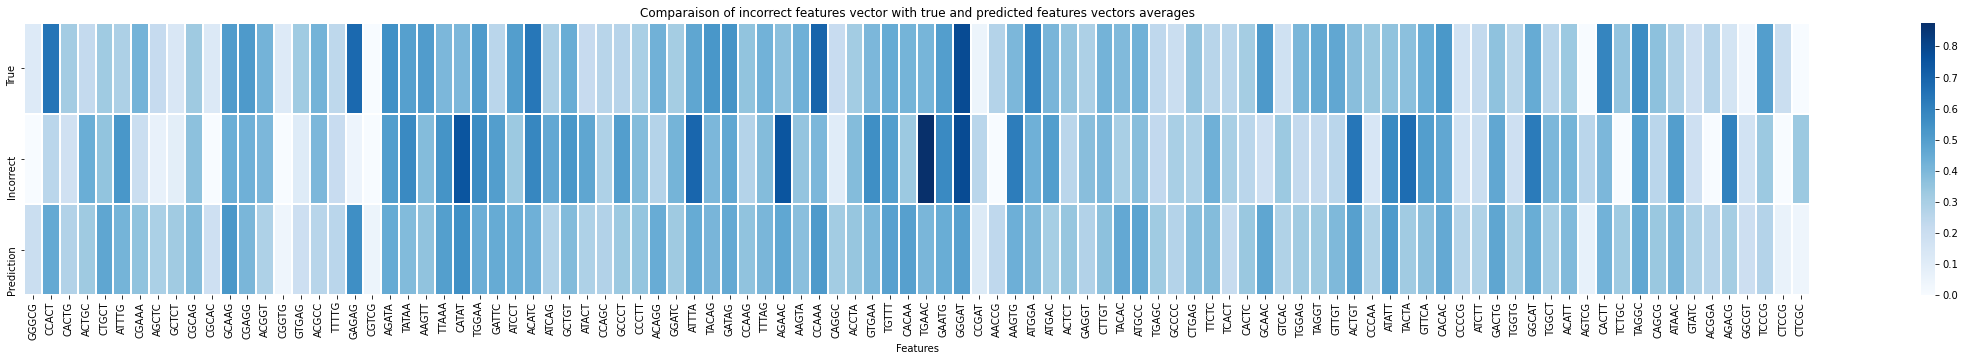

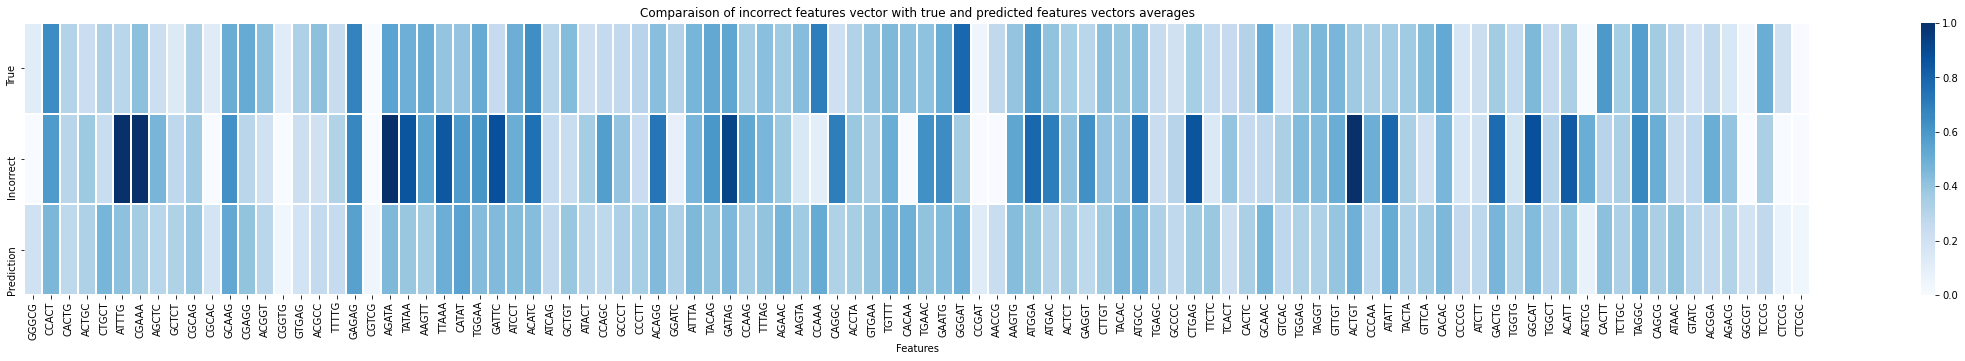

In [40]:
# For all incorrect records, compute average feature vectors of all correct records for both true and predicted classes
for i_data, i_features in zip(incorrect_data[0:max_incorrect], incorrect_features[0:max_incorrect]):
    # Both matrices to plot
    true_features = []
    pred_features = []
    # Iterate through correct records
    for c_data, c_features in zip(correct_data, correct_features):
        # Compare only if both records are somewhat similar (either same subtype or acgt-percentage range)
        #if i_data.annotations["subtype"] == c_data.annotations["subtype"] or i_data.annotations["acgt-percent"] == c_data.annotations["acgt-percent"]:
        # If this correct record is in the same class as current incorrect record
        if i_data.annotations["target"] == c_data.annotations["target"]:
            true_features.append(c_features)
        # If this correct record is in the class that the current incorrect record has been predicted to  
        if i_data.annotations["prediction"] == c_data.annotations["target"]:
            pred_features.append(c_features)
    # Compute avergare matrices only if similar correct records are found (avoid div per 0)
    if len(true_features) != 0 and len(pred_features) != 0:
        true_features_mean = np.array(true_features).mean(axis=0)
        pred_features_mean = np.array(pred_features).mean(axis=0)
        # Build the heatmap
        fig, ax = plt.subplots(figsize=(40,5))
        sns.heatmap([true_features_mean, i_features, pred_features_mean], 
                #annot = True, 
                #fmt = ".0f", 
                linewidth = 0.1,
                cmap = 'Blues',
                xticklabels = features.instances,
                yticklabels = ["True", "Incorrect", "Prediction"],)
        plt.title("Comparaison of incorrect features vector with true and predicted features vectors averages")
        plt.xlabel("Features")
        plt.show()


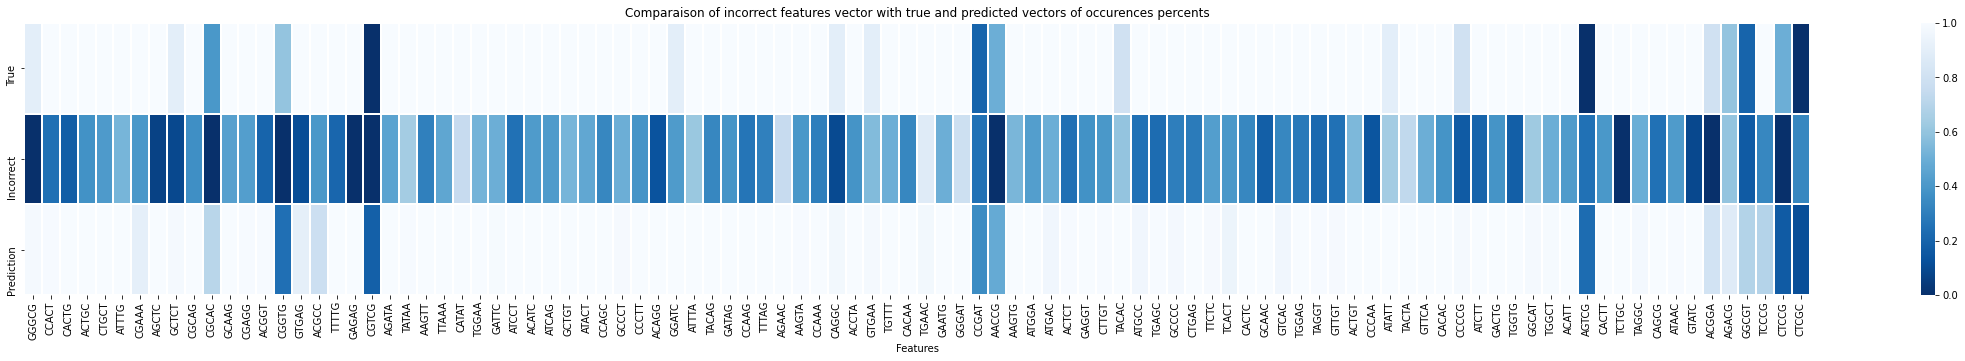

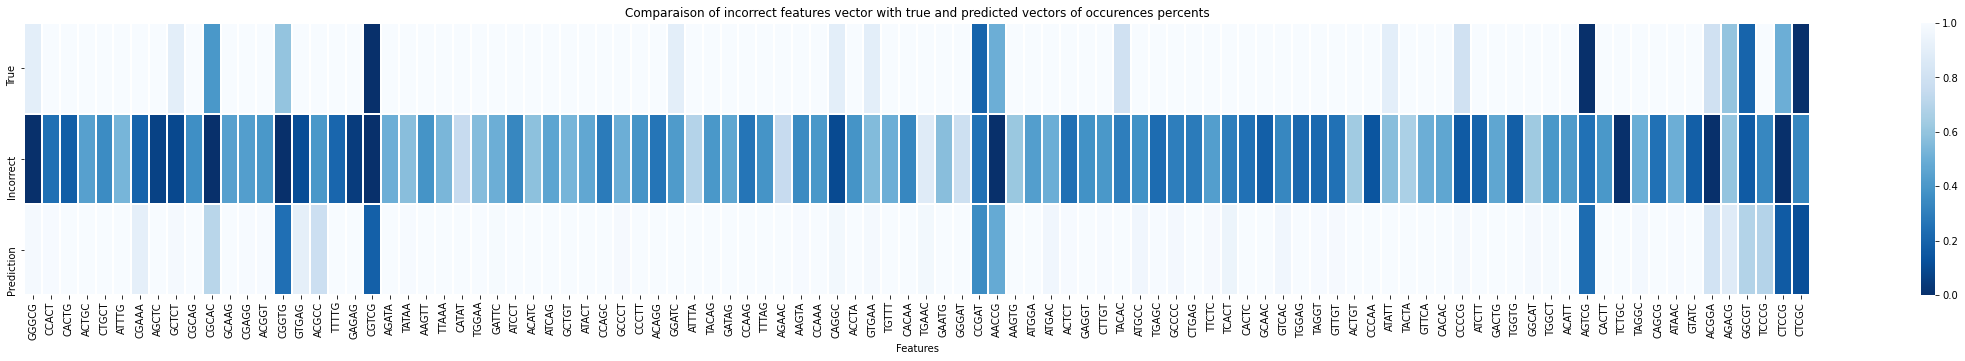

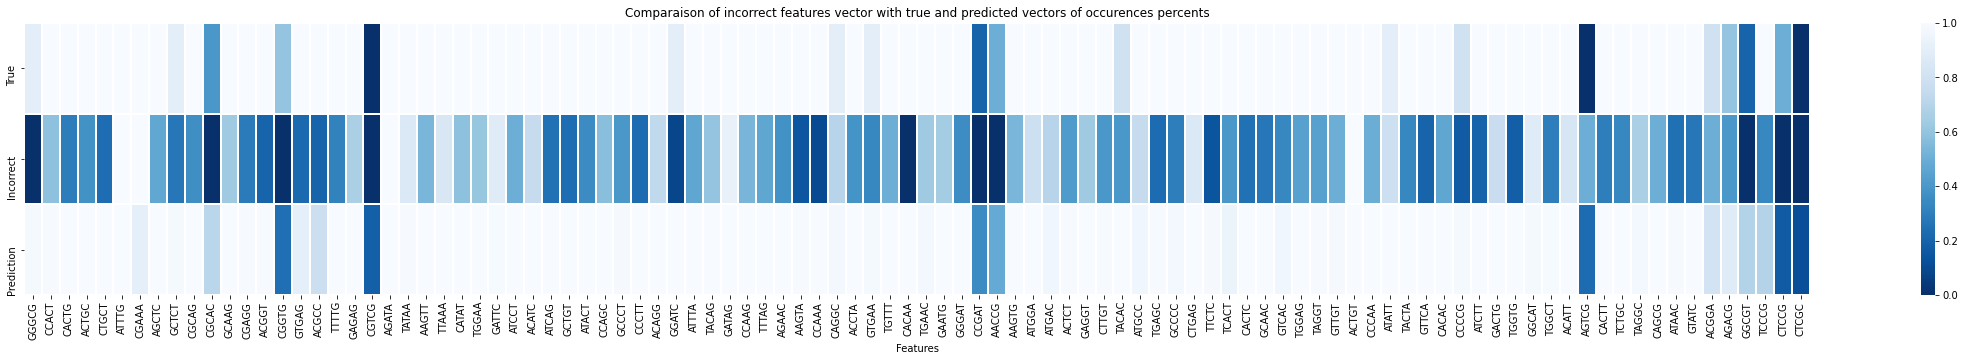

In [41]:
# For all incorrect records, compare apparence percentage of all correct records in both true and predicted classes
for i_data, i_features in zip(incorrect_data[0:max_incorrect], incorrect_features[0:max_incorrect]):
    # Dictionaries containing nb of occurences of features for all correct records
    true_features = {}
    pred_features = {}
    true_features = true_features.fromkeys(features.instances, 0)
    pred_features = pred_features.fromkeys(features.instances, 0)
    true_total = 0
    pred_total = 0
    # Iterate through correct records
    for c_data, c_features in zip(correct_data, correct_features):
        # Compare only if both records are somewhat similar (either same subtype or acgt-percentage range)
        #if i_data.annotations["subtype"] == c_data.annotations["subtype"] or i_data.annotations["acgt-percent"] == c_data.annotations["acgt-percent"]:
        # If this correct record is in the same class as current incorrect record
        if i_data.annotations["target"] == c_data.annotations["target"]:
            true_total += 1
            for value, key in zip(c_features, features.instances):
                if value > 0: true_features[key] += 1
        # If this correct record is in the class that the current incorrect record has been predicted to  
        if i_data.annotations["prediction"] == c_data.annotations["target"]:
            pred_total += 1
            for value, key in zip(c_features, features.instances):
                if value > 0: pred_features[key] += 1
    # Compute avergare matrices only if similar correct records are found (avoid div per 0)
    if true_total != 0 and pred_total != 0:
        true_vector = list(map((lambda i: i / true_total), true_features.values()))
        pred_vector = list(map((lambda i: i / pred_total), pred_features.values()))
        # Build the heatmap
        fig, ax = plt.subplots(figsize=(40,5))
        sns.heatmap([true_vector, i_features, pred_vector], 
                #annot = True, 
                #fmt = ".0f", 
                linewidth = 0.1,
                cmap = 'Blues_r',
                xticklabels = features.instances,
                yticklabels = ["True", "Incorrect", "Prediction"],)
        plt.title("Comparaison of incorrect features vector with true and predicted vectors of occurences percents")
        plt.xlabel("Features")
        plt.show()

  0% (2 of 3000) |                       | Elapsed Time: 0:00:03 ETA:   1:26:14
Comparison of alignement scores between true and predicted class:
100% (3000 of 3000) |####################| Elapsed Time: 1:22:17 ETA:  00:00:00

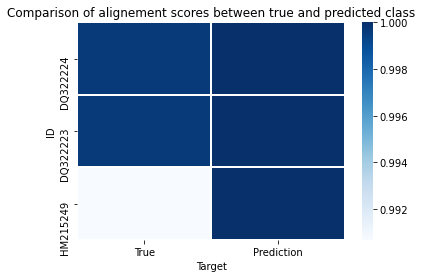

In [42]:
# Compute alignement of all incorrect records to all correct record and compute avegarge of scores
print("\nComparison of alignement scores between true and predicted class:")
ids = []
matrix = []
# Used to show progress
progress = ProgressBar(max_value=len(incorrect_data[0:max_incorrect])*len(correct_data[0:max_correct])).start()
count = 0
# Shuffle correct data (when we're sampling it)
shuffle(correct_data)
# Iterate through incorrect data
for i in incorrect_data[0:max_incorrect]:
    # Keep different averages for same target class and predicted target class of incorrect record
    true_score_sum = 0
    true_score_nb = 0
    pred_score_sum = 0
    pred_score_nb = 0
    # Iterate through correct data
    for c in correct_data[0:max_correct]:
        # Compare only if both records are somewhat in the same category (both same subtype and acgt-percentage range)
        #if i.annotations["subtype"] == c.annotations["subtype"] and i.annotations["acgt-percent"] == c.annotations["acgt-percent"]:
        # If this correct record is in the same class as current incorrect record
        if i.annotations["target"] == c.annotations["target"]:
            true_score_sum += pairwise2.align.globalxx(i.seq, c.seq, score_only=True)
            true_score_nb += 1
        # If this correct record is in the class that the current incorrect record has been predicted to
        if i.annotations["prediction"] == c.annotations["target"]:
            pred_score_sum += pairwise2.align.globalxx(i.seq, c.seq, score_only=True)
            pred_score_nb += 1
        # Used to show progress
        count += 1
        progress.update(count)
    # Compute avergare only if similar correct records are found (avoid div per 0)
    if true_score_nb != 0 and pred_score_nb != 0:
        ids.append(i.id)
        matrix.append([true_score_sum/true_score_nb, pred_score_sum/pred_score_nb])
# Normalise results
matrix = pd.DataFrame(np.array(matrix))
matrix = matrix.div(matrix.max(axis=1), axis=0)
# Build the heatmap
fig, ax = plt.subplots()
sns.heatmap(matrix, 
            #annot = True, 
            #fmt = ".0f", 
            linewidth = 0.1,
            cmap = 'Blues',
            xticklabels = ["True", "Prediction"], 
            yticklabels = ids)
plt.title("Comparison of alignement scores between true and predicted class")
plt.xlabel("Target")
plt.ylabel("ID")
plt.show()

In [43]:
# Tried something, did not work yet...

#features = create(["GGCGG"])
#for i in incorrect_data:
#    graphic_features = []
#    progress = ProgressBar()
#    for pos, seq in progress(features.instances.search(i.seq)):
#        graphic_features.append(GraphicFeature(start = pos, end= pos + k, strand = +1, color= "#ffd700", label=str(seq + "\n" + "Position : " + str(pos))))
#    record = GraphicRecord(sequence_length = len(i.seq), features=graphic_features)
#    record.plot(figure_width = 15)
#    plt.title("Sequence : " + i.id) 
#    plt.show()
#for c in correct_data:
#    if c.annotations["target"] == "CRB":
#        graphic_features = []
#        progress = ProgressBar()
#        for pos, seq in progress(features.instances.search(i.seq)):
#            graphic_features.append(GraphicFeature(start = pos, end= pos + k, strand = +1, color= "#ffd700", label=str(seq + "\n" + "Position : " + str(pos))))
#        record = GraphicRecord(sequence_length = len(i.seq), features=graphic_features)
#        record.plot(figure_width = 15)
#        plt.title("Sequence : " + c.id) 
#        plt.show()
#        break
#for c in correct_data:
#    if c.annotations["target"] == "OCE":
#        graphic_features = []
#        progress = ProgressBar()
#        for pos, seq in progress(features.instances.search(i.seq)):
#            graphic_features.append(GraphicFeature(start = pos, end= pos + k, strand = +1, color= "#ffd700", label=str(seq + "\n" + "Position : " + str(pos))))
#        record = GraphicRecord(sequence_length = len(i.seq), features=graphic_features)
#        record.plot(figure_width = 15)
#        plt.title("Sequence : " + c.id) 
#        plt.show()
#        break